## Predict protein abundance from ribosome occupancy and protein half-life

In [1]:
%%HTML
<style>
div.rendered_html p { font-size: 16px; }
div.rendered_html { background-color: #f4ecd8 }
div.output_html { background-color: unset}
</style>

In [2]:
import functools
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
import grove

import seaborn as sns
import matplotlib.pyplot as plt

from scripts.general import preprocess

### Abundance data: Ho (2018)

In [3]:
prot_abundance = pd.read_csv('../../data/ho2018/prot_abundance_molecules_per_cell_no_gfp.csv')
prot_abundance = prot_abundance[['Systematic_Name', 'swissprot_ac', 'Median_molecules_per_cell']]

seq_len = preprocess.fasta_to_seq_df(
    '../../data/seq/scerevisiae_aminoacid_uniprot_20200120.fasta'
)
seq_len = seq_len.assign(
    seq_len = seq_len['seq'].map(len)
).drop(columns='seq')

### Half-life data: Christiano et al. (2014)

Saccharomyces cerevisiae lysine auxotroph of strain [BY4742](https://www.yeastgenome.org/strain/BY4742). 
Variation between BY4742 and S288C is miniscule.

In [4]:
halflife = pd.read_excel('../../data/protein_stability/christiano_2014_table_s1.xlsx', 
                         sheet_name='Sheet1')
halflife = halflife.rename(columns={
    't1/2 (hours)': 'halflife_h',
    'UNIPROT': 'swissprot_ac'
})
halflife = halflife.query('halflife_h != ">= 100"')
halflife['halflife_h'] = halflife['halflife_h'].astype('float32')    

halflife = halflife[['swissprot_ac', 'halflife_h']]
halflife = halflife.dropna()

halflife['swissprot_ac'] = halflife['swissprot_ac'].map(lambda s: s.split(';'))
halflife = halflife.explode('swissprot_ac')

print('Dataset size:', halflife.shape[0])

Dataset size: 3854


### Ribosome occupancy data: Weinberg (2016)

Strain [BY4741](https://www.yeastgenome.org/strain/BY4741), a descendant of S288C with minuscule differences.

RPF counts are adjusted using an empirically-derived position-dependent correction factor. [Weinberg (2016)](https://doi.org/10.1016/j.celrep.2016.01.043)

In [5]:
rpf_counts_weinberg2016 = pd.read_csv(
    '../../data/ribosome_profiling/weinberg2016_GSE75897_RPF_RPKMs.txt.gz', 
    sep='\t', header=None, names=['Systematic_Name', 'RPF_RPKM']
)

mrna_counts_weinberg2016 = pd.read_csv(
    '../../data/ribosome_profiling/weinberg2016_GSE75897_RiboZero_RPKMs.txt.gz', 
    sep='\t', header=None, names=['Systematic_Name_err', 'mRNA_RPKM']
)

Fix corrupted `Systematic_Name` in mRNA data

In [6]:
sysname_lookup = rpf_counts_weinberg2016[['Systematic_Name']].assign(
    Systematic_Name_err = rpf_counts_weinberg2016['Systematic_Name'].map(
        lambda sysname: sysname.replace('-', '')
    )
)

mrna_counts_weinberg2016 = mrna_counts_weinberg2016.merge(sysname_lookup).drop(columns='Systematic_Name_err')

In [7]:
weinberg2016_data = pd.merge(
    rpf_counts_weinberg2016,
    mrna_counts_weinberg2016
)

# Drop effectively zero values (so we can take log)
machine_epsilon = np.finfo('float32').eps
weinberg2016_data = weinberg2016_data.query('(RPF_RPKM > @machine_epsilon) & (mRNA_RPKM > @machine_epsilon)')

print(weinberg2016_data.shape[0], 'entries')

5240 entries


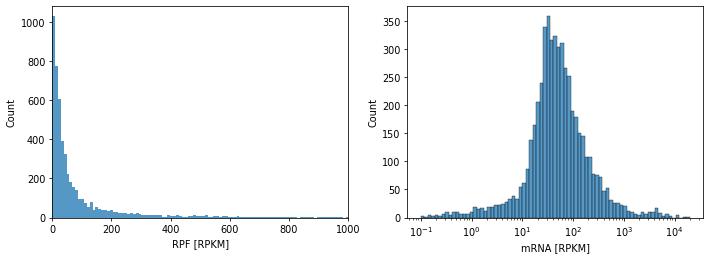

In [8]:
plt.figure(dpi=70, figsize=(12, 4))

plt.subplot(1,2,1)
sns.histplot(weinberg2016_data, x='RPF_RPKM').set(xlabel='RPF [RPKM]', xlim=(0, 1000));
plt.subplot(1,2,2)
sns.histplot(weinberg2016_data, x='mRNA_RPKM', log_scale=(True, False)).set(xlabel='mRNA [RPKM]');

## Inspect data and perform sanity checks

Don't include half-life just yet. Inspect relationships between mRNA, RPF, and length with all available data.

### Pool and process data

Log10-transform all variables

In [9]:
prot_data = (
    grove.merge([
            weinberg2016_data,
            prot_abundance,
            seq_len
        ],
        on = ['Systematic_Name', 'swissprot_ac']
    )
)

print(prot_data.shape[0], 'entries')
prot_data.head(2)

4998 entries


,Systematic_Name,RPF_RPKM,mRNA_RPKM,swissprot_ac,Median_molecules_per_cell,seq_len
0,YAL001C,18.12,37.80,P34111,1809.0,1160
1,YAL002W,5.73,22.17,P39702,1353.0,1274


In [10]:
rpf_rpkm = np.log10(prot_data[['RPF_RPKM']].values)
mrna_rpkm = np.log10(prot_data[['mRNA_RPKM']].values)

length = np.log10(prot_data[['seq_len']].values)

abundance = np.log10(prot_data[['Median_molecules_per_cell']].values)

In [11]:
rnd_seed = 42
test_fract = 0.2
std_split = functools.partial(train_test_split, test_size=test_fract, random_state=rnd_seed)

In [12]:
rpf_rpkm_train, rpf_rpkm_test = std_split(rpf_rpkm)      # R
mrna_rpkm_train, mrna_rpkm_test = std_split(mrna_rpkm)   # m
length_train, length_test = std_split(length)            # L
abundance_train, abundance_test = std_split(abundance)   # A

In [13]:
abundance_train.shape[0]

3998

In [14]:
abundance_test.shape[0]

1000

#### Derived variables

In [15]:
transl_eff = rpf_rpkm - mrna_rpkm   # (Weinberg, 2016) TE = R / m, so take log(R) - log(m)
rel_density = transl_eff - length   # (Riba, 2019)        = TE / L

### Assess relations between the various variables

Verifying that `TE` and `L` are inversely correlated in the Weinberg (2016) data **[OK]**

In [16]:
stats.spearmanr(transl_eff, length)

SpearmanrResult(correlation=-0.611156295206171, pvalue=0.0)

Given the above and how these variables are defined, it seems like the ribosome occupancy (RPF) $R$ could be expressed as a log-linear model of mRNA $m$ and inverse protein length $L$, namely:

$$
log(R) = a \cdot log(m) + b \cdot log(L) + c
$$

where b should be negative.
As both R and m are RPMK, the length informtion in these terms will cancel out.

In [17]:
from sklearn import linear_model

R_mL = linear_model.LinearRegression()

R_mL.fit(X = np.concatenate((mrna_rpkm_train, length_train), axis=1), 
         y = rpf_rpkm_train)

R_mL.score(np.concatenate((mrna_rpkm_test, length_test), axis=1), 
           rpf_rpkm_test)

0.878103946643635

In [18]:
R_mL.coef_, R_mL.intercept_

(array([[ 1.19500582, -0.45374423]]), array([0.69265427]))

This means that, acc. to Weinberg (2016) data,

$$
R \sim \frac{m}{L}
$$

specifically, $R = 10^{0.69} \frac{m^{1.19}}{L^{0.45}} \approx 4.9 \frac{m}{\sqrt{L}}$ acc. to the log-linear model fit above.

This is effectively the inverse in terms of $L$ to the TASEP model used by Riba (2019).

It also means $TE \propto \frac{1}{\sqrt{L}}$ (which checks out, given their negative correlation).

And the *relative density* defined in Riba (2019) as $\frac{TE}{L} \propto \frac{1}{L\sqrt{L}}$.

As the fit isn't perfect ($R^2$ = 88%), the relation above doesn't fully explain how these variables are related.

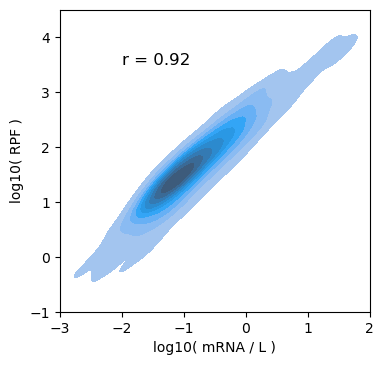

In [19]:
plt.figure(dpi=100, figsize=(4, 4))

sns.kdeplot(
    x = (mrna_rpkm - length).ravel(),
    y = (rpf_rpkm).ravel(),
    fill = True
).set(
    xlabel = 'log10( mRNA / L )',
    ylabel = 'log10( RPF )',
    xlim=(-3, 2),
    ylim=(-1, 4.5)
);

plt.annotate(
    f'r = {stats.spearmanr(mrna_rpkm - length, rpf_rpkm)[0] :.2}',
    xy=(-2, 3.5), size = 'large'
);

### Correlations

All Spearman unless marked otherwise, as few of these distributions are near normal, and to be consistent.

In [20]:
print(f'A ~ m : {stats.spearmanr(abundance, mrna_rpkm)[0] :.2}')
print(f'A ~ R : {stats.spearmanr(abundance, rpf_rpkm)[0] :.2}')
print(f'A ~ L : {stats.spearmanr(abundance, length)[0] :.2}')
print()
print(f'R ~ m : {stats.spearmanr(rpf_rpkm, mrna_rpkm)[0] :.2}')

A ~ m : 0.77
A ~ R : 0.81
A ~ L : -0.18

R ~ m : 0.93


#### Sanity check with Riba (2019) data

Check that the correlations they reported hold here, both with [RPKM] Weinberg data, and the RPF [counts] in the Riba data.

https://www.pnas.org/doi/suppl/10.1073/pnas.1817299116/suppl_file/pnas.1817299116.sapp.pdf

For the former, the exact values would differ, due to the change in units (and implicit factoring of length).

m ~ R should be high **[OK]**

In [21]:
stats.spearmanr(mrna_rpkm, rpf_rpkm)

SpearmanrResult(correlation=0.9266209584830353, pvalue=0.0)

m L ~ R should be lower that m ~ R (inverse corr of L)  **[OK]**

The value is much lower since R is still [RPKM]. Removing the 1 / L factor, to get ~[reads] as in Riba makes the drop lower.

In [22]:
stats.spearmanr(mrna_rpkm + length, rpf_rpkm)

SpearmanrResult(correlation=0.6278967349409744, pvalue=0.0)

In [23]:
stats.spearmanr(mrna_rpkm + length, rpf_rpkm + length)

SpearmanrResult(correlation=0.8973876337344139, pvalue=0.0)

R / L ~ A reported at Spearman r = 0.72 **[OK]**

SInce R [RPKM] / L ~ R [counts] / L^2, we are also recovering R as ~[reads] by taking R [RPKM] * L. This yields a higher correlation, though still close to the expected value.

In [24]:
stats.spearmanr(rpf_rpkm - length, abundance)

SpearmanrResult(correlation=0.7141816119664208, pvalue=0.0)

In [25]:
stats.spearmanr(rpf_rpkm + length, abundance)

SpearmanrResult(correlation=0.7769885205347662, pvalue=0.0)

Using Riba RPF [reads] values

In [26]:
riba = pd.read_csv('../../data/riba2019/pnas.1817299116.sd02.tsv', sep='\t')
riba = riba.rename(columns={'uniprotswissprot': 'swissprot_ac', 'ensembl_gene_id': 'Systematic_Name'})

riba_weinberg = grove.merge(
    [riba[['Systematic_Name', 'ribo_reads', 'orf_length']],
     weinberg2016_data,
     prot_abundance],
    on = 'Systematic_Name'
)

riba_weinberg.head(2)

,Systematic_Name,ribo_reads,orf_length,RPF_RPKM,mRNA_RPKM,swissprot_ac,Median_molecules_per_cell
0,YPL228W,0.000040,550,45.20,43.84,O13297,3705.0
1,YLR390W-A,0.000351,239,837.21,317.21,O13547,7590.0


Sanity check (RPF [reads] / L) ~ RPF [RPKM]  **[OK]**

In [27]:
stats.spearmanr(riba_weinberg['ribo_reads'] / riba_weinberg['orf_length'], riba_weinberg['RPF_RPKM'])

SpearmanrResult(correlation=0.9996297340192916, pvalue=0.0)

In [28]:
stats.pearsonr(riba_weinberg['ribo_reads'] / riba_weinberg['orf_length'], riba_weinberg['RPF_RPKM'])

(0.9930683377397556, 0.0)

m ~ R should be high (Spearman r = 0.9) **[OK]**

In [29]:
stats.spearmanr(np.log10(riba_weinberg['mRNA_RPKM']), 
                np.log10(riba_weinberg['ribo_reads']))

SpearmanrResult(correlation=0.9025735346964668, pvalue=0.0)

m L ~ R should be lower that m ~ R (Spearman r = 0.87) <span style='color:red'>**[NOT OK: increases]**</span>

As m is [RPKM], m L ~ m [reads], thus correlating m [reads] with R [reads].

In [30]:
stats.spearmanr(np.log10(riba_weinberg['mRNA_RPKM'] * riba_weinberg['orf_length']), 
                np.log10(riba_weinberg['ribo_reads']))

SpearmanrResult(correlation=0.9452981221355979, pvalue=0.0)

R / L ~ A reported at Spearman r = 0.72 **[OK, though higher]**

In [31]:
stats.spearmanr(np.log10(riba_weinberg['ribo_reads'] / riba_weinberg['orf_length']), 
                np.log10(riba_weinberg['Median_molecules_per_cell']))

SpearmanrResult(correlation=0.8231309928938075, pvalue=1.0746230356772208e-251)

#### Sanity check

Using the `ribo_reads` values in Riba (2019) leads to a **discrepancy** in the interplay of m (mRNA), L (ORF length), and R (RPFs):

Removing the 1 / L factor from m [RPKM] (by taking m * L) increases m correlations with R [reads] slightly,
whereas in the Weinberg (2016) data, it makes it drop, the latter naturally consistent with inverse relationship between R (reads) and L observed here.

Throughout this study, **only the Weinberg (2016) values will be used**.

Double-check that removing 1 / L in [RPKM] reduces correlation **[OK]**

In [32]:
stats.spearmanr(abundance, mrna_rpkm + length)

SpearmanrResult(correlation=0.5973277404388525, pvalue=0.0)

In [33]:
stats.spearmanr(abundance, rpf_rpkm + length)

SpearmanrResult(correlation=0.7769885205347662, pvalue=0.0)

Is the residual of the ribosome occupancy liner model correlated with abundance?

I.e. is there information left about abundance after controlling for mRNA and length?

In [34]:
R_residual = rpf_rpkm - R_mL.predict(np.concatenate((mrna_rpkm, length), axis=1))

print(f'R_res ~ A : {stats.spearmanr(R_residual, abundance)[0] :.2}')

R_res ~ A : 0.22


Some information left (though how much is actual noise is unclear).

## Model protein abundance in terms of ribosome occupancy and half-life

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Pool and process data

Log10-transform all variables

In [36]:
prot_data = (
    grove.merge([
            weinberg2016_data,
            prot_abundance,
            halflife,
            seq_len
        ],
        on = ['Systematic_Name', 'swissprot_ac', 'swissprot_ac']
    )
)

print(prot_data.shape[0], 'entries')


rpf_rpkm = np.log10(prot_data[['RPF_RPKM']].values)
mrna_rpkm = np.log10(prot_data[['mRNA_RPKM']].values)

length = np.log10(prot_data[['seq_len']].values)

halflife = np.log10(prot_data[['halflife_h']].values)
abundance = np.log10(prot_data[['Median_molecules_per_cell']].values)

transl_eff = rpf_rpkm - mrna_rpkm   # (Weinberg, 2016) TE = R / m, so take log(R) - log(m)
rel_density = transl_eff - length   # (Riba, 2019) = TE / L

rpf_rpkm_train, rpf_rpkm_test = std_split(rpf_rpkm)      # R
mrna_rpkm_train, mrna_rpkm_test = std_split(mrna_rpkm)   # m
length_train, length_test = std_split(length)            # L
halflife_train, halflife_test = std_split(halflife)      # H
abundance_train, abundance_test = std_split(abundance)   # A

3574 entries


In [37]:
abundance_train.shape[0]

2859

In [38]:
abundance_test.shape[0]

715

### Correlations

All Spearman unless marked otherwise, as few of these distributions are near normal and for consistency.
These will differ slightly from the sanity checks above, since we're working with a protein subset resulting from intersecting with the half-life data.

In [39]:
print(f'A ~ m : {stats.spearmanr(abundance, mrna_rpkm)[0] :.2}')
print(f'A ~ R : {stats.spearmanr(abundance, rpf_rpkm)[0] :.2}')
print(f'A ~ L : {stats.spearmanr(abundance, length)[0] :.2}')
print(f'A ~ H : {stats.spearmanr(abundance, halflife)[0] :.2}')
print()
print(f'R ~ m : {stats.spearmanr(rpf_rpkm, mrna_rpkm)[0] :.2}')
print(f'R ~ H : {stats.spearmanr(rpf_rpkm, halflife)[0] :.2}')

A ~ m : 0.83
A ~ R : 0.85
A ~ L : -0.17
A ~ H : 0.34

R ~ m : 0.92
R ~ H : 0.21


## Model using residual mRNA

Interesting to see what information left after accounting for both $m$ and $L$ with a linear fit.

### Prepare model input

In [40]:
R_mL = linear_model.LinearRegression()

R_mL.fit(X = np.concatenate((mrna_rpkm_train, length_train), axis=1), 
         y = rpf_rpkm_train)

R_mL.score(np.concatenate((mrna_rpkm_test, length_test), axis=1), 
           rpf_rpkm_test)

0.9350978590221762

In [41]:
R_residual = rpf_rpkm - R_mL.predict(np.concatenate((mrna_rpkm, length), axis=1))

print(f'R_res ~ A : {stats.spearmanr(R_residual, abundance)[0] :.2}')

R_res ~ A : 0.29


In [42]:
abundance_predictors = np.concatenate(
    (R_residual, halflife), 
    axis=1
)

abundance_predictors_train, abundance_predictors_test = std_split(abundance_predictors)

### Linear model

In [43]:
lm = linear_model.LinearRegression()

lm.fit(abundance_predictors_train, abundance_train.ravel())
lm.score(abundance_predictors_test, abundance_test.ravel())

0.1115975583482367

### Random forest model

In [44]:
rand_forest_search = GridSearchCV(
    RandomForestRegressor(random_state=rnd_seed), 
    param_grid={
        'n_estimators': [10, 20, 50, 100, 200],
        'min_samples_leaf': [2, 10, 50],
        'max_features': [1, 2]
    },
    cv=KFold(n_splits=5, shuffle=True, random_state=rnd_seed),
    scoring='neg_mean_squared_error',
    verbose=1
)
rand_forest_search.fit(abundance_predictors_train, abundance_train.ravel())

print()
print(f'Best candidate MSE: {-rand_forest_search.best_score_ : .2}')
print(f'Test R^2: {rand_forest_search.best_estimator_.score(abundance_predictors_test, abundance_test.ravel()): .2}')
print
print('Best params: ', rand_forest_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best candidate MSE:  0.17
Test R^2:  0.15
Best params:  {'max_features': 1, 'min_samples_leaf': 50, 'n_estimators': 200}


In [45]:
rand_forest = RandomForestRegressor(
    n_estimators = 200,
    min_samples_leaf = 50,
    max_features = 1,
    oob_score = True,
    n_jobs = 4,
    random_state=rnd_seed
)

rand_forest.fit(abundance_predictors_train, abundance_train.ravel())

print(f'R^2: {rand_forest.score(abundance_predictors_test, abundance_test.ravel()): .2}')

print('\nFeature importance')
print(f'- R_res: {rand_forest.feature_importances_[0]: .2}%')
print(f'- H: {rand_forest.feature_importances_[1]: .2}%')

R^2:  0.15

Feature importance
- R_res:  0.33%
- H:  0.67%


### SVM model

In [46]:
svm = SVR(kernel='rbf', C=1e-2, gamma=10)

svm.fit(abundance_predictors_train, abundance_train.ravel())
svm.score(abundance_predictors_test, abundance_test.ravel())

0.14760001957921343

In [47]:
# SLOW

# svm_search = GridSearchCV(
#     make_pipeline(StandardScaler(), SVR(degree=3, cache_size=1600)), 
#     param_grid={
#       'svr__C': [1e-2, 1e-1, 1],
#       'svr__gamma': [1e-1, 1, 10],
#       'svr__kernel': ['poly', 'rbf']
#     },
#     scoring='neg_mean_squared_error',
#     cv=KFold(n_splits=5, shuffle=True, random_state=rnd_seed),
#     verbose=3,
#     n_jobs=1
# )
# svm_search.fit(abundance_predictors_train, abundance_train.ravel())

# print()
# print('Best candidate MSE:', -svm_search.best_score_)
# print('Test R^2:', svm_search.best_estimator_.score(abundance_predictors_test, abundance_test.ravel()))
# print(svm_search.best_params_)

### KNN  model

In [48]:
knn_search = GridSearchCV(KNeighborsRegressor(), 
                          param_grid={
                              'n_neighbors': [10, 100, 200, 400, 800, 1000],
                              'weights': ['uniform', 'distance'],
                              'p': [1, 2]
                          },
                          scoring='neg_mean_squared_error',
                          cv=KFold(n_splits=5, shuffle=True, random_state=rnd_seed),
                          verbose=1
                         )
knn_search.fit(abundance_predictors_train, abundance_train.ravel())

print()
print(f'Best candidate MSE: {-knn_search.best_score_ : .2}')
print(f'Test R^2: {knn_search.best_estimator_.score(abundance_predictors_test, abundance_test.ravel()): .4}')
print
print('Best params: ', knn_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best candidate MSE:  0.17
Test R^2:  0.1497
Best params:  {'n_neighbors': 100, 'p': 1, 'weights': 'uniform'}


In [49]:
knn = KNeighborsRegressor(n_neighbors=100,
                          weights='uniform',
                          p=2,
                          n_jobs=-1)

knn.fit(abundance_predictors_train, abundance_train.ravel())
knn.score(abundance_predictors_test, abundance_test.ravel())

0.151201958318392

## Model using translation efficiency

In [50]:
abundance_predictors_te = np.concatenate(
    (transl_eff, halflife), 
    axis=1
)

abundance_predictors_te_train, abundance_predictors_te_test = std_split(abundance_predictors_te)

In [51]:
lm_te = linear_model.LinearRegression()

lm_te.fit(abundance_predictors_te_train, abundance_train.ravel())
lm_te.score(abundance_predictors_te_test, abundance_test.ravel())

0.29350735930247884

In [52]:
knn_search_te = GridSearchCV(
    KNeighborsRegressor(), 
    param_grid={
        'n_neighbors': [10, 100, 200, 400, 800, 1000],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    cv=KFold(n_splits=5, shuffle=True, random_state=rnd_seed),
    verbose=1
)
knn_search_te.fit(abundance_predictors_te_train, abundance_train.ravel())

print()
print(f'Best candidate R^2: {knn_search_te.best_score_ : .2}')
print(f'Test R^2: {knn_search_te.best_estimator_.score(abundance_predictors_te_test, abundance_test.ravel()): .2}')
print
print('Best params: ', knn_search_te.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best candidate R^2:  0.39
Test R^2:  0.35
Best params:  {'n_neighbors': 100, 'p': 1, 'weights': 'uniform'}


In [53]:
knn_te = KNeighborsRegressor(n_neighbors=100,
                             weights='uniform',
                             p=1,
                             n_jobs=-1)

knn_te.fit(abundance_predictors_te_train, abundance_train.ravel())
knn_te.score(abundance_predictors_te_test, abundance_test.ravel())

0.34847357104972754

In [54]:
svm_te = SVR(kernel='rbf', C=0.1, gamma=10)

svm_te.fit(abundance_predictors_te_train, abundance_train.ravel())
svm_te.score(abundance_predictors_te_test, abundance_test.ravel())

0.36688097294629385

In [55]:
rand_forest_search_te = GridSearchCV(
    RandomForestRegressor(random_state=rnd_seed), 
    param_grid={
        'n_estimators': [10, 20, 50, 100, 200],
        'min_samples_leaf': [2, 10, 50],
        'max_features': [1, 2]
    },
    cv=KFold(n_splits=5, shuffle=True, random_state=rnd_seed),
    scoring='neg_mean_squared_error',
    verbose=1
)
rand_forest_search_te.fit(abundance_predictors_te_train, abundance_train.ravel())

print()
print(f'Best candidate MSE: {-rand_forest_search_te.best_score_ : .2}')
print(f'Test R^2: {rand_forest_search_te.best_estimator_.score(abundance_predictors_te_test, abundance_test.ravel()): .2}')
print
print('Best params: ', rand_forest_search_te.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best candidate MSE:  0.13
Test R^2:  0.36
Best params:  {'max_features': 1, 'min_samples_leaf': 50, 'n_estimators': 200}


In [56]:
rand_forest_te = RandomForestRegressor(
    n_estimators = 200,
    min_samples_leaf = 50,
    max_features = 1,
    n_jobs = 4,
    random_state=rnd_seed
)

rand_forest_te.fit(abundance_predictors_te_train, abundance_train.ravel())

print(f'R^2: {rand_forest_te.score(abundance_predictors_te_test, abundance_test.ravel()): .4}')

print('\nFeature importance')
print(f'- TE: {rand_forest_te.feature_importances_[0]: .2}%')
print(f'- H: {rand_forest_te.feature_importances_[1]: .2}%')

R^2:  0.3618

Feature importance
- TE:  0.65%
- H:  0.35%


In [57]:
abundance_test.shape

(715, 1)

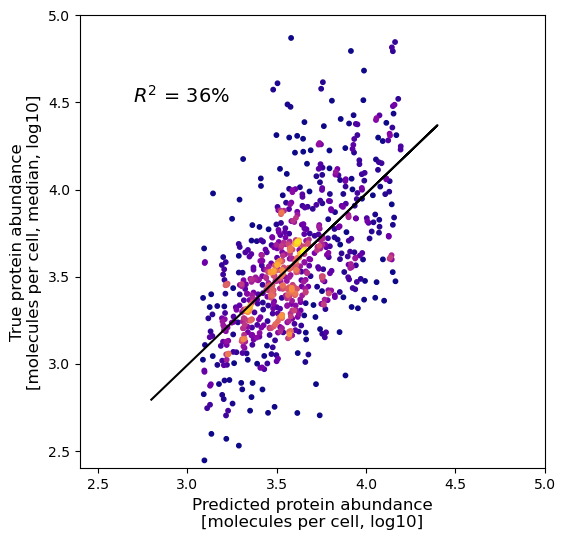

In [58]:
from scripts.general import plotting


rf_predicted_values = rand_forest_te.predict(abundance_predictors_te_test).reshape(-1, 1)

plot_regresssion = linear_model.LinearRegression().fit(rf_predicted_values, abundance_test)


plt.figure(dpi=100, figsize = (6, 6))
label_fontsize = 12

plotting.scatter_density(
    x = rf_predicted_values.ravel(),
    y = abundance_test.ravel(),
    s = 10
)

reg_x = np.insert(np.insert(rf_predicted_values, 0, 2.8), -1, 4.4).reshape(-1, 1)
plt.plot(reg_x, plot_regresssion.predict(reg_x), color ='k')
plt.xlim(2.4, 5)
plt.ylim(2.4, 5)

plt.annotate(f'$R^2$ = {rand_forest_te.score(abundance_predictors_te_test, abundance_test.ravel())*100:.0f}%',
             xy=(2.7, 4.5),
             fontsize=14)

plt.xlabel('Predicted protein abundance\n[molecules per cell, log10]', fontsize=label_fontsize)
plt.ylabel('True protein abundance\n[molecules per cell, median, log10]', fontsize=label_fontsize);

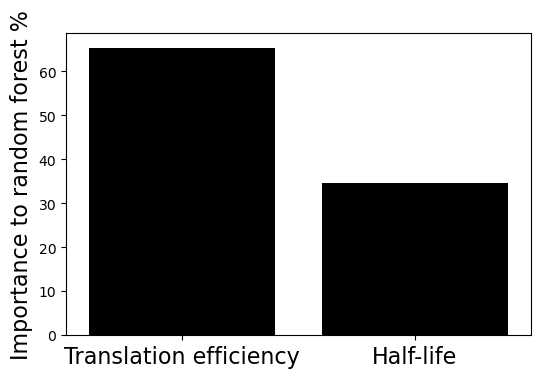

In [59]:
plt.figure(dpi=100)

sns.barplot(
    x=[0,1], y=rand_forest_te.feature_importances_ * 100, 
    color='k'
).set_xticklabels(['Translation efficiency', 'Half-life'], fontsize=16);
plt.ylabel('Importance to random forest %', fontsize=16);

## Model using length-normalized TE

Based on the fit found here of $TE \propto \frac{1}{\sqrt{L}}$, normalize for $\sqrt{L}$

The results are effectively the same as for non-normalized TE, meaning the impact of length is minuscule in these data. Indeed $\sqrt{L}$ seems to account for 0.3% of explained variance, which is a questionable level in terms of actual (general) importance, especially given the imperfect fit (88% $R^2$) the nornmalization is based on.

In [60]:
te_norm = transl_eff + 0.5 * length   #  TE * sqrt(L)

abundance_predictors_te_norm = np.concatenate(
    (te_norm, halflife), 
    axis=1
)

abundance_predictors_te_norm_train, abundance_predictors_te_norm_test = std_split(abundance_predictors_te_norm)

In [61]:
rf_search_te_norm = GridSearchCV(
    RandomForestRegressor(random_state=rnd_seed), 
    param_grid={
        'n_estimators': [10, 20, 50, 100, 200, 600, 800],
        'min_samples_leaf': [2, 10, 50],
        'max_features': [1, 2]
    },
    cv=KFold(n_splits=5, shuffle=True, random_state=rnd_seed),
    scoring='neg_mean_squared_error',
    verbose=1
)
rf_search_te_norm.fit(abundance_predictors_te_norm_train, abundance_train.ravel())

print()
print(f'Best candidate MSE: {-rf_search_te_norm.best_score_ : .2}')
print(f'Test R^2: {rf_search_te_norm.best_estimator_.score(abundance_predictors_te_norm_test, abundance_test.ravel()) :.4}')
print()
print('Best params: ', rf_search_te_norm.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best candidate MSE:  0.12
Test R^2: 0.3411

Best params:  {'max_features': 2, 'min_samples_leaf': 50, 'n_estimators': 100}


In [62]:
rand_forest_te_norm = RandomForestRegressor(
    n_estimators = 100,
    min_samples_leaf = 80,
    max_features = 1,
    n_jobs = 4,
    random_state=rnd_seed
)

rand_forest_te_norm.fit(abundance_predictors_te_norm_train, abundance_train.ravel())

print(f'R^2: {rand_forest_te_norm.score(abundance_predictors_te_norm_test, abundance_test.ravel()): .4}')

print('\nFeature importance')
print(f'- TE_norm: {rand_forest_te_norm.feature_importances_[0]: .2}%')
print(f'- H: {rand_forest_te_norm.feature_importances_[1]: .2}%')

R^2:  0.3583

Feature importance
- TE_norm:  0.68%
- H:  0.32%


## Model using ribosome occupancy directly

The fit will be much better, of course, since R "contains" the mRNA information, which corelates well with A.

In [63]:
abundance_predictors_full = np.concatenate(
    (rpf_rpkm, halflife), 
    axis=1
)

abundance_predictors_full_train, abundance_predictors_full_test = std_split(abundance_predictors_full)

In [64]:
lm_full = linear_model.LinearRegression()

lm_full.fit(abundance_predictors_full_train, abundance_train.ravel())
lm_full.score(abundance_predictors_full_test, abundance_test.ravel())

0.7459618287973724

In [65]:
rf_search_full = GridSearchCV(
    RandomForestRegressor(random_state=rnd_seed), 
    param_grid={
        'n_estimators': [10, 20, 50, 100, 200, 600, 800],
        'min_samples_leaf': [2, 10, 50],
        'max_features': [1, 2]
    },
    cv=KFold(n_splits=5, shuffle=True, random_state=rnd_seed),
    scoring='neg_mean_squared_error',
    verbose=1
)
rf_search_full.fit(abundance_predictors_full_train, abundance_train.ravel())

print()
print(f'Best candidate MSE: {-rf_search_full.best_score_ : .2}')
print(f'Test R^2: {rf_search_full.best_estimator_.score(abundance_predictors_full_test, abundance_test.ravel()) :.4}')
print()
print('Best params: ', rf_search_full.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best candidate MSE:  0.046
Test R^2: 0.764

Best params:  {'max_features': 1, 'min_samples_leaf': 10, 'n_estimators': 800}


In [66]:
rand_forest_full = RandomForestRegressor(
    n_estimators = 600,
    min_samples_leaf = 2,
    max_features = 1,
    n_jobs = 4,
    random_state=rnd_seed
)

rand_forest_full.fit(abundance_predictors_full_train, abundance_train.ravel())

print(f'R^2: {rand_forest_full.score(abundance_predictors_full_test, abundance_test.ravel()): .4}')

print('\nFeature importance')
print(f'- R: {rand_forest_full.feature_importances_[0]: .2}%')
print(f'- H: {rand_forest_full.feature_importances_[1]: .2}%')

R^2:  0.7676

Feature importance
- R:  0.8%
- H:  0.2%
